In [2]:
# Load packages

import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as sfm

from matplotlib.widgets import Slider, Button, RadioButtons
#from scipy import interp
from scipy.optimize import fsolve
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from statsmodels.formula.api import ols


from IPython.display import display_html

In [3]:

df = pd.read_csv('Lending_club_cleaned_2.csv')


df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=['Charged Off', 'Fully Paid']))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=['< 1 year', '1 year', '2 years', '3 years', '4 years', \
                                                             '5 years', '6 years', '7 years', '8 years', '9 years', \
                                                             '10+ years']))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=['RENT','MORTGAGE','OWN','OTHER']))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[' 36 months', ' 60 months']))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=['A','B','C','D','E','F','G']))

# int_rate tiene strings como esto 'x.xx%',
#removemos el % y cambiamos a float
df.int_rate = df.int_rate.str.rstrip('%').astype('float')
df

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
...,...,...,...,...,...,...,...,...,...,...
38700,Fully Paid,110000.0,Not Verified,4 years,MORTGAGE,8.07,2500,home_improvement,36 months,A
38701,Fully Paid,18000.0,Not Verified,3 years,RENT,10.28,8500,credit_card,36 months,C
38702,Fully Paid,100000.0,Not Verified,< 1 year,MORTGAGE,8.07,5000,debt_consolidation,36 months,A
38703,Fully Paid,200000.0,Not Verified,< 1 year,MORTGAGE,7.43,5000,other,36 months,A


|      annual_inc     |                                                 The self-reported annual income provided by the borrower during registration.                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| verification_status |                                          Indicates if income was verified by LC, not verified, or if the income source was verified                                          |
|      emp_length     |                       Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                      |
|    home_ownership   |             The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER            |
|       int_rate      |                                                                           Interest Rate on the loan                                                                          |
|      loan_amnt      | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
|       purpose       |                                                           A category provided by the borrower for the loan request.                                                          |
|         term        |                                             The number of payments on the loan. Values are in months and can be either 36 or 60.                                             |
|        grade        |                                                                            LC assigned loan grade                                                                            |

# EDA

<Axes: xlabel='loan_status', ylabel='loan_amnt'>

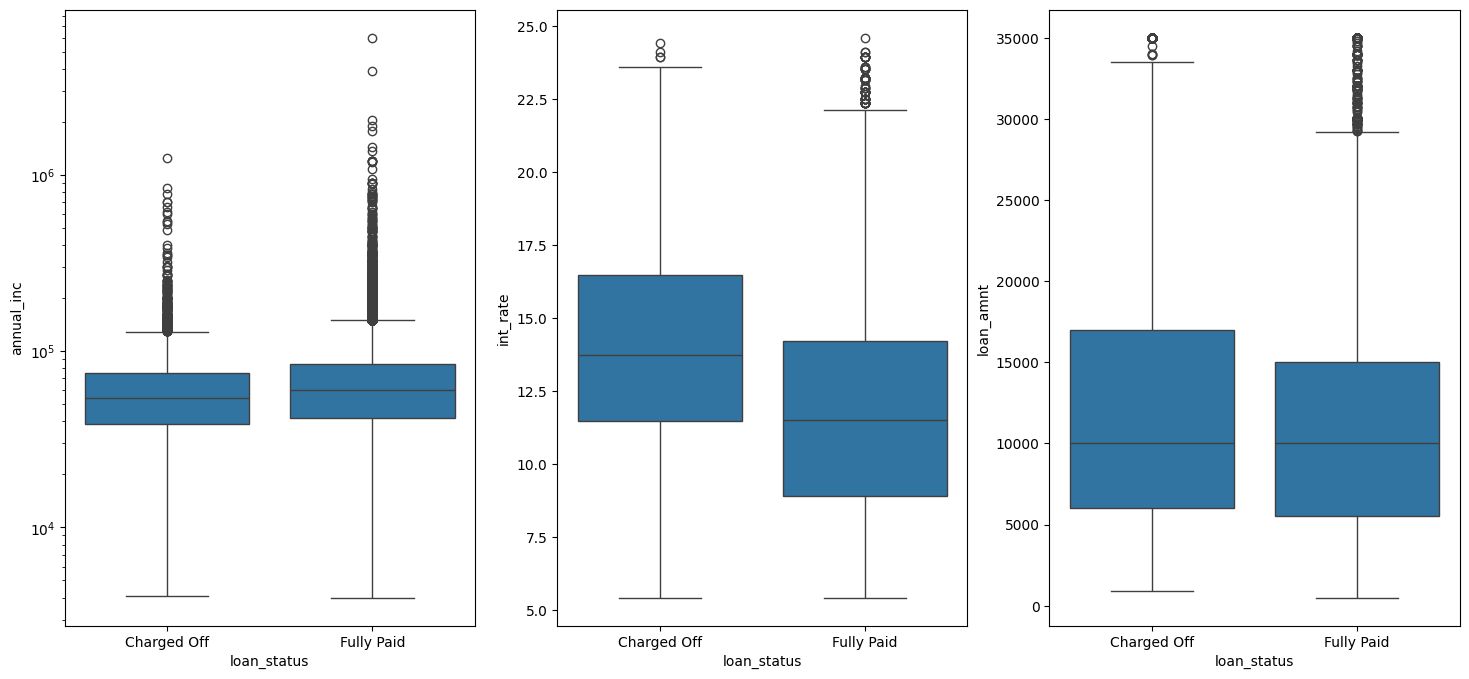

In [5]:
fig, ax=plt.subplots(1,3, figsize=(18,8))
sns.boxplot(y='annual_inc', x='loan_status', data=df, ax=ax[0]).set_yscale('log')
sns.boxplot(y='int_rate', x ='loan_status', data = df, ax=ax[1])
sns.boxplot(y='loan_amnt', x='loan_status', data=df, ax=ax[2])

**Pregunta:** Observan algo interesante de estos graficos?

**Pregunta:** 
Considere la siguiente afirmación:

> "A partir de estos gráficos podemos concluir que el ingreso anual no juega un papel significativo a la hora de decidir si un usuario pagará o no su préstamo".

¿Cree que esta afirmación es correcta? ¿Cómo intentaría comprobarlo?

Puedes hacer una prueba t de dos muestras y comprobar si las *medias* son diferentes:

**Pregunta:** Si recuerdan aprendimos que podemos usar tablas de contingencia para examinar la relación entre dos variables discretas. Se puede realizar una prueba de chi-cuadrado en función de la tabla de contingencia para verificar si la relación observada es estadísticamente significativa. 

Realizar una tabla de contingencia entre `loan_status` y otra variable dada llamada `var`:

**Pregunta:** ¿Qué puede ver en la tabla anterior? ¿Podemos concluir que la verificación de la fuente de ingresos no es necesaria para nuestro cliente?

**Pregunta:** 
Usa el test de chi cuadrado para verificar si las asociacion entre `verification_status` y `loan_status` es significativa

**Ayuda:** Puedes usar `chi2, p, dof, ex=chi2_contingency(pd.crosstab(index=x,columns=y))`


Como primera aproximación, creemos un modelo lineal que tenga como objetivo explicar `loan_status` utilizando las variables proporcionadas en nuestro conjunto de datos. Observe que `loan_status` es una variable categórica, por lo que es necesario convertirla en variable dummy antes. 

Además, dado que las variables `verification_status`, `grade` y `term` son ordinales, también podríamos usar sus códigos categóricos (esto supondría que los saltos en las categorías son iguales, lo que podría ser razonable para algunas de estas variables). Usa la tabla `df2` ya preparada para esto.

La formula si la necesitas es esta: 
`'loan_status~verification_status+annual_inc+loan_amnt+int_rate+term'`

In [7]:
df2=df.copy()

var_names=['loan_status','verification_status','grade','term']
for var in var_names:
    df2[var]=df2[var].cat.codes
    
var_names2=['annual_inc','int_rate','loan_amnt']
for var in var_names2:
    df2[var]=(df2[var]-df2[var].mean())/df2[var].std()
df2

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,1,-0.710290,2,10+ years,RENT,-0.378954,-0.843862,credit_card,0,1
1,0,-0.616866,1,< 1 year,RENT,0.863143,-1.178519,car,1,2
2,1,-0.893213,0,10+ years,RENT,1.048651,-1.191906,small_business,0,2
3,1,-0.317912,1,10+ years,RENT,0.384586,-0.174546,other,0,2
4,1,0.161661,1,1 year,RENT,0.169505,-1.111588,other,1,1
...,...,...,...,...,...,...,...,...,...,...
38700,1,0.628778,0,4 years,MORTGAGE,-1.072592,-1.178519,home_improvement,0,0
38701,1,-0.803713,0,3 years,RENT,-0.478429,-0.375341,credit_card,0,2
38702,1,0.473072,0,< 1 year,MORTGAGE,-1.072592,-0.843862,debt_consolidation,0,0
38703,1,2.030128,0,< 1 year,MORTGAGE,-1.244658,-0.843862,other,0,0


**Pregunta:** Que puedes observar de esto?

**Pregunta:** Intentemos implementar un modelo de regresion logistica para esto puedes usar este codigo de ejemplo

```python
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])
df_log1['verification_status'] = df.verification_status.cat.codes
df_log1['loan_status'] = df.loan_status.cat.codes
df_log1['Intercept'] = 1

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
logit_res.summary()
```

**Pregunta:** Ahora intenta hacer lo mismo con este nuevo modelo, notas alguna diferencia?

```python
df6=df.copy()
df6['loan_status'] = df6.loan_status.cat.codes
df6['loan_amnt']=(df6['loan_amnt']-df6['loan_amnt'].mean())/df6['loan_amnt'].std()
df6['int_rate']=(df6['int_rate']-df6['int_rate'].mean())/df6['int_rate'].std()
df6['Intercept'] = 1

logit2 = sm.Logit(df6['loan_status'], df6[['Intercept','loan_amnt','int_rate']])
logit_res2 = logit2.fit()
logit_res2.summary()
```